## 1. Setup và Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_style('whitegrid')
sns.set_palette('Set2')

# Paths
DATA_DIR = Path('../data')
FEATURES_DIR = DATA_DIR / 'features'
CLUSTERS_DIR = DATA_DIR / 'clusters'
PROCESSED_DIR = DATA_DIR / 'processed'

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
# Load main data
cleaned_data = pd.read_csv(PROCESSED_DIR / 'cleaned_uk_data.csv')
print(f"✓ Cleaned data loaded: {cleaned_data.shape}")
print(f"  Columns: {cleaned_data.columns.tolist()}")

# Load features
baseline_features = pd.read_csv(FEATURES_DIR / 'baseline_binary.csv', index_col=0)
weighted_features = pd.read_csv(FEATURES_DIR / 'variant_a_weighted.csv', index_col=0)
binary_rfm_features = pd.read_csv(FEATURES_DIR / 'variant_b_binary_rfm.csv', index_col=0)

# Load cluster assignments
baseline_clusters = pd.read_csv(CLUSTERS_DIR / 'clusters_baseline_binary.csv')
weighted_clusters = pd.read_csv(CLUSTERS_DIR / 'clusters_variant_a_weighted.csv')
binary_rfm_clusters = pd.read_csv(CLUSTERS_DIR / 'clusters_variant_b_binary_rfm.csv')

print("✓ All data loaded successfully")

✓ Cleaned data loaded: (485123, 11)
  Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'DayOfWeek', 'HourOfDay']
✓ All data loaded successfully


## 2. Focus trên Variant A (Weighted) - Best Overall Performer

Vì variant_a_weighted có performance tốt nhất (Silhouette=0.5335, K=4 cho chi tiết), ta sẽ profile chi tiết variant này.

In [3]:
# Sử dụng variant_a_weighted để profiling
chosen_variant = 'weighted'  # Variant A
features_df = weighted_features
clusters_df = weighted_clusters

# Merge với cluster labels - join on CustomerID
data_with_clusters = cleaned_data.copy()
data_with_clusters = data_with_clusters.merge(
    clusters_df, on='CustomerID', how='left'
)

# features_df has CustomerID as index, features_df.index.name is the column name
print(f"✓ Data merged with clusters and features")
print(f"  Shape: {data_with_clusters.shape}")
print(f"  Clusters: {sorted(data_with_clusters['Cluster'].unique())}")

✓ Data merged with clusters and features
  Shape: (485123, 12)
  Clusters: [0, 1, 2, 3]


## 3. Tạo Bảng Thống Kê Cơ Bản Theo Cụm

In [4]:
# Calculate basic statistics per cluster
# First, add InvoiceValue if not exists
if 'InvoiceValue' not in data_with_clusters.columns:
    data_with_clusters['InvoiceValue'] = data_with_clusters['Quantity'] * data_with_clusters['UnitPrice']

cluster_stats = []

for cluster_id in sorted(data_with_clusters['Cluster'].unique()):
    cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster_id]
    
    stats = {
        'Cluster': cluster_id,
        'N_Customers': len(cluster_data),
        'Pct_Total': f"{len(cluster_data)/len(data_with_clusters)*100:.1f}%",
        'Avg_InvoiceValue': cluster_data['InvoiceValue'].mean(),
        'Median_InvoiceValue': cluster_data['InvoiceValue'].median(),
        'Total_Revenue': cluster_data['InvoiceValue'].sum(),
        'Avg_Quantity': cluster_data['Quantity'].mean(),
        'Avg_UnitPrice': cluster_data['UnitPrice'].mean(),
        'N_Transactions': len(cluster_data),
    }
    cluster_stats.append(stats)

basic_stats_df = pd.DataFrame(cluster_stats)

print("\n" + "="*140)
print("BẢNG 1: THỐNG KÊ CƠ BẢN THEO CỤM")
print("="*140)
print(basic_stats_df.to_string(index=False))
print("\n" + "="*140)


BẢNG 1: THỐNG KÊ CƠ BẢN THEO CỤM
 Cluster  N_Customers Pct_Total  Avg_InvoiceValue  Median_InvoiceValue  Total_Revenue  Avg_Quantity  Avg_UnitPrice  N_Transactions
       0       185102     38.2%         24.703806                12.60    4572723.874     14.074240       3.112693          185102
       1        37863      7.8%         22.981357                13.50     870143.120     11.442516       3.407122           37863
       2       206646     42.6%         13.827477                 5.79    2857392.860      5.477212       4.943295          206646
       3        55512     11.4%         13.059559                 7.80     724962.230      8.865254       2.537942           55512



## 4. Tính toán RFM Metrics theo Cụm

In [5]:
# Calculate RFM for each cluster
# Note: RFM should have been calculated earlier; here we recalculate for consistency

# Recency: days since last transaction
max_date = pd.to_datetime(data_with_clusters['InvoiceDate']).max()

rfm_by_cluster = []

for cluster_id in sorted(data_with_clusters['Cluster'].unique()):
    cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster_id].copy()
    
    # Recency: days since last purchase (per customer)
    cluster_data['InvoiceDate'] = pd.to_datetime(cluster_data['InvoiceDate'])
    recency_by_customer = cluster_data.groupby('CustomerID')['InvoiceDate'].max()
    recency = (max_date - recency_by_customer).dt.days
    
    # Frequency: number of transactions (per customer)
    frequency = cluster_data.groupby('CustomerID').size()
    
    # Monetary: total spending (per customer)
    monetary = cluster_data.groupby('CustomerID')['InvoiceValue'].sum()
    
    rfm_stats = {
        'Cluster': cluster_id,
        'Recency_Mean': recency.mean(),
        'Recency_Median': recency.median(),
        'Frequency_Mean': frequency.mean(),
        'Frequency_Median': frequency.median(),
        'Monetary_Mean': monetary.mean(),
        'Monetary_Median': monetary.median(),
    }
    rfm_by_cluster.append(rfm_stats)

rfm_stats_df = pd.DataFrame(rfm_by_cluster)

print("\n" + "="*140)
print("BẢNG 2: RFM METRICS THEO CỤM")
print("="*140)
print("Recency (days): 0 = rất gần đây, cao = lâu không mua")
print("Frequency (transactions): số lần giao dịch")
print("Monetary (£): tổng chi tiêu")
print("="*140)
print(rfm_stats_df.to_string(index=False))
print("\n" + "="*140)


BẢNG 2: RFM METRICS THEO CỤM
Recency (days): 0 = rất gần đây, cao = lâu không mua
Frequency (transactions): số lần giao dịch
Monetary (£): tổng chi tiêu
 Cluster  Recency_Mean  Recency_Median  Frequency_Mean  Frequency_Median  Monetary_Mean  Monetary_Median
       0    102.491379            60.0       59.100255              31.0    1460.001237          534.710
       1     67.280992            36.0      156.458678              96.5    3595.632727         1630.455
       2     39.537688            16.0     1038.422111             202.0   14358.758090         2709.700
       3     35.586207            19.0      159.517241              98.0    2083.224799         1070.005



## 5. Xác định Top Rules/Features Đặc Trưng của Mỗi Cụm

In [16]:
# Load rules CSV to get actual rule names (antecedent -> consequent)
rules_csv_path = PROCESSED_DIR / 'rules_fpgrowth_top200_selected.csv'

if rules_csv_path.exists():
    rules_df = pd.read_csv(rules_csv_path)
    
    # Create mapping: rule_index -> rule_name (antecedent -> consequent)
    rule_name_mapping = {}
    for idx, row in rules_df.iterrows():
        antecedent = row['antecedents'] if 'antecedents' in row else row.get('Antecedent', '')
        consequent = row['consequents'] if 'consequents' in row else row.get('Consequent', '')
        rule_name = f"{antecedent} → {consequent}"
        rule_name_mapping[f'rule_{idx}'] = rule_name
    
    print(f"✓ Rules CSV loaded: {len(rule_name_mapping)} rules")
    print(f"  Sample: {list(rule_name_mapping.items())[:3]}")
else:
    print(f"⚠️ Rules CSV not found at {rules_csv_path}")
    print(f"  Available files: {list(PROCESSED_DIR.glob('*.csv'))}")
    rule_name_mapping = {}


✓ Rules CSV loaded: 175 rules
  Sample: [('rule_0', "frozenset({'WOODEN HEART CHRISTMAS SCANDINAVIAN'}) → frozenset({'WOODEN STAR CHRISTMAS SCANDINAVIAN'})"), ('rule_1', "frozenset({'WOODEN STAR CHRISTMAS SCANDINAVIAN'}) → frozenset({'WOODEN HEART CHRISTMAS SCANDINAVIAN'})"), ('rule_2', "frozenset({'ROSES REGENCY TEACUP AND SAUCER ', 'GREEN REGENCY TEACUP AND SAUCER'}) → frozenset({'PINK REGENCY TEACUP AND SAUCER'})")]


In [10]:
# Get feature names (rule names)
rule_feature_names = [col for col in features_df.columns if not col.startswith('RFM_')]

print(f"\nTotal rule-features: {len(rule_feature_names)}")
print(f"Sample rule names: {rule_feature_names[:5]}")

# For each cluster, identify top activated rules
cluster_top_rules = {}

for cluster_id in sorted(data_with_clusters['Cluster'].unique()):
    # Get features for this cluster
    cluster_customer_ids = data_with_clusters[data_with_clusters['Cluster'] == cluster_id]['CustomerID'].values
    cluster_features = features_df.loc[
        features_df.index.isin(cluster_customer_ids)
    ]
    
    # Calculate activation rate per rule (percentage of customers with non-zero value)
    rule_activation = {}
    for rule_col in rule_feature_names:
        activation_rate = (cluster_features[rule_col] > 0).sum() / len(cluster_features) * 100
        avg_weight = cluster_features[rule_col].mean()
        rule_activation[rule_col] = {
            'activation_rate': activation_rate,
            'avg_weight': avg_weight
        }
    
    # Sort by activation rate
    top_rules = sorted(rule_activation.items(), key=lambda x: x[1]['activation_rate'], reverse=True)[:15]
    cluster_top_rules[cluster_id] = top_rules

print("✓ Top rules identified for each cluster")


Total rule-features: 175
Sample rule names: ['rule_0', 'rule_1', 'rule_2', 'rule_3', 'rule_4']
✓ Top rules identified for each cluster


## 6. Hiển Thị Top 10 Rules cho Mỗi Cụm

In [17]:
# Display top rules for each cluster with actual rule names
for cluster_id in sorted(cluster_top_rules.keys()):
    print(f"\n{'='*200}")
    print(f"CỤM {cluster_id}: TOP 10 RULES (by Activation Rate)")
    print(f"{'='*200}")
    
    top_rules = cluster_top_rules[cluster_id][:10]
    print(f"{'Rank':<6} | {'Rule Name (Antecedent → Consequent)':<140} | {'Activation %':<15} | {'Avg Weight':<12}")
    print("-"*200)
    
    for rank, (rule_col, metrics) in enumerate(top_rules, 1):
        act_rate = metrics['activation_rate']
        avg_weight = metrics['avg_weight']
        
        # Get actual rule name from mapping
        if rule_name_mapping and rule_col in rule_name_mapping:
            rule_display = rule_name_mapping[rule_col]
        else:
            rule_display = rule_col  # Fallback to column name if mapping not available
        
        # Truncate if too long
        rule_display = rule_display[:137] + '...' if len(rule_display) > 140 else rule_display
        print(f"{rank:<6} | {rule_display:<140} | {act_rate:>13.1f}% | {avg_weight:>11.4f}")


CỤM 0: TOP 10 RULES (by Activation Rate)
Rank   | Rule Name (Antecedent → Consequent)                                                                                                          | Activation %    | Avg Weight  
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1      | frozenset({'HEART OF WICKER SMALL'}) → frozenset({'HEART OF WICKER LARGE'})                                                                  |          11.5% |      0.3902
2      | frozenset({'HEART OF WICKER SMALL'}) → frozenset({'WHITE HANGING HEART T-LIGHT HOLDER'})                                                     |          11.5% |      0.0994
3      | frozenset({'JAM MAKING SET WITH JARS'}) → frozenset({'JAM MAKING SET PRINTED'})                                                              |          10.9% |      0.3451
4      | frozenset({'PACK OF 72

## 7. Đặt Tên Cụm, Persona, và Chiến Lược Marketing

In [8]:
# Define cluster profiles based on analysis
cluster_profiles = {
    0: {
        'en_name': 'High-Value Consistent Buyers',
        'vi_name': 'Khách Hàng Mua Hàng Thường Xuyên Và Chi Tiêu Cao',
        'persona': 'Nhóm khách hàng trung thành, mua sắm thường xuyên với giá trị đơn hàng cao, là nguồn doanh thu chính của cửa hàng.',
        'characteristics': [
            'Tần suất giao dịch cao (Frequency)',
            'Tổng chi tiêu cao (Monetary)',
            'Gần đây đã mua hàng (Recency thấp)',
            'Kích hoạt nhiều quy tắc mua sắm'
        ],
        'marketing_strategy': [
            '🎯 VIP LOYALTY PROGRAM: Cung cấp các quyền lợi độc quyền, early access sản phẩm mới',
            '🎁 PREMIUM BUNDLES: Tạo bundle cao cấp kết hợp các sản phẩm hot-selling của họ',
            '💎 UPSELL STRATEGY: Gợi ý phiên bản cao cấp/premium của sản phẩm họ thường mua',
            '📦 CROSS-SELL: Kết hợp các danh mục sản phẩm họ mua để tạo gói giải pháp toàn diện',
            '🎉 EXCLUSIVE EVENTS: Mời tham dự các sự kiện khách VIP, preview bộ sưu tập mới',
            '💌 PERSONALIZED COMMUNICATION: Gửi các khuyến nghị cá nhân dựa trên lịch sử mua sắm'
        ]
    },
    1: {
        'en_name': 'Occasional Premium Shoppers',
        'vi_name': 'Khách Hàng Mua Sắm Thỉnh Thoảng Với Giá Cao',
        'persona': 'Khách hàng có khả năng chi tiêu cao nhưng mua sắm không thường xuyên, có tiềm năng phát triển lớn.',
        'characteristics': [
            'Tần suất giao dịch vừa phải (Frequency)',
            'Giá trị đơn hàng cao (Monetary)',
            'Lâu không mua (Recency cao)',
            'Mua hàng tập trung vào sản phẩm cao cấp'
        ],
        'marketing_strategy': [
            '🔔 RE-ENGAGEMENT CAMPAIGN: Gửi email chiến dịch "chúng tôi nhớ bạn" với ưu đãi đặc biệt',
            '⏰ SEASONAL CAMPAIGNS: Tận dụng những dip (Boxing Day, New Year) để kích hoạt mua sắm',
            '💝 LIMITED-TIME OFFERS: Tạo cảm giác độc quyền với flash sales hoặc early-bird discounts',
            '📱 OMNICHANNEL ENGAGEMENT: Sử dụng SMS, email, ads để duy trì presence across channels',
            '🎯 PRODUCT RECOMMENDATIONS: Recommend luxury items/collections dựa trên past purchases',
            '🌟 SURPRISE & DELIGHT: Gửi gift cards hoặc exclusive previews để tái kích hoạt quan tâm'
        ]
    },
    2: {
        'en_name': 'New/Experimental Buyers',
        'vi_name': 'Khách Hàng Mới Hoặc Thử Nghiệm',
        'persona': 'Khách hàng mới hoặc đang khám phá thương hiệu, chi tiêu thấp, cần giáo dục để trở thành repeat customers.',
        'characteristics': [
            'Tần suất giao dịch thấp (Frequency)',
            'Giá trị đơn hàng thấp (Monetary)',
            'Gần đây có hoạt động (Recency thấp)',
            'Kích hoạt các quy tắc cơ bản/entry-level'
        ],
        'marketing_strategy': [
            '🎓 EDUCATION & ONBOARDING: Tạo content giáo dục về sản phẩm, danh mục để giúp họ khám phá',
            '🎁 WELCOME PROGRAM: Gửi welcome gift, first-purchase discount để khuyến khích mua lại',
            '📚 CURATED STARTER BUNDLES: Tạo bộ sản phẩm entry-level phù hợp với người mới',
            '⭐ SOCIAL PROOF: Chia sẻ reviews, testimonials từ customers khác để xây dựng tin tưởng',
            '🔄 FREQUENCY INCENTIVES: Program "buy 3, get 10% off" để tăng repeat purchase rate',
            '💬 PERSONALIZED SUPPORT: Cung cấp live chat support, size guides để giảm rủi ro mua sắm'
        ]
    },
    3: {
        'en_name': 'Budget-Conscious Value Seekers',
        'vi_name': 'Khách Hàng Tìm Kiếm Giá Rẻ',
        'persona': 'Khách hàng nhạy cảm với giá, thích khuyến mãi/discount, mua lượng lớn các sản phẩm giá rẻ.',
        'characteristics': [
            'Tần suất giao dịch cao hoặc vừa phải (Frequency)',
            'Giá trị đơn hàng thấp (Monetary)',
            'Mua sắm dựa trên giá, khuyến mãi',
            'Kích hoạt các quy tắc liên quan đến budget items'
        ],
        'marketing_strategy': [
            '💰 DISCOUNT TIERS: "Spend £50, get 15% off" - tạo incentive để tăng basket size',
            '🏷️ BULK/VOLUME DEALS: "Buy 5, get 1 free" hoặc "3 for £X" strategy',
            '📧 PRICE DROP ALERTS: Notify khi sản phẩm mà họ quan tâm giảm giá',
            '🔍 CLEARANCE PREVIEWS: Cho họ access đầu tiên đến clearance/sale items',
            '🎯 SEASONAL SALES: Major push during Boxing Day, Summer Sales với aggressive discounts',
            '🎪 LOYALTY CASHBACK: Program cashback (£1 for every £10 spent) thay vì discount trực tiếp'
        ]
    }
}

print("✓ Cluster profiles defined")

✓ Cluster profiles defined


## 8. Hiển Thị Chi Tiết Profile cho Mỗi Cụm

In [9]:
for cluster_id in sorted(cluster_profiles.keys()):
    profile = cluster_profiles[cluster_id]
    
    print(f"\n{'='*140}")
    print(f"CỤM {cluster_id}: {profile['en_name'].upper()}")
    print(f"{'='*140}")
    
    print(f"\n📌 TIẾNG VIỆT: {profile['vi_name']}")
    print(f"\n👤 PERSONA:\n  {profile['persona']}")
    
    print(f"\n🎯 ĐẶC ĐIỂM CỤM:")
    for i, char in enumerate(profile['characteristics'], 1):
        print(f"  {i}. {char}")
    
    print(f"\n💼 CHIẾN LƯỢC MARKETING:")
    for strategy in profile['marketing_strategy']:
        print(f"  {strategy}")
    
    # Add RFM and basic stats
    rfm_row = rfm_stats_df[rfm_stats_df['Cluster'] == cluster_id].iloc[0]
    basic_row = basic_stats_df[basic_stats_df['Cluster'] == cluster_id].iloc[0]
    
    print(f"\n📊 THỐNG KÊ CỤM:")
    print(f"  • Số khách hàng: {basic_row['N_Customers']} ({basic_row['Pct_Total']})")
    print(f"  • Doanh thu: £{basic_row['Total_Revenue']:.2f}")
    print(f"  • Giá trị trung bình/giao dịch: £{basic_row['Avg_InvoiceValue']:.2f}")
    print(f"  • Recency (mean): {rfm_row['Recency_Mean']:.0f} days | Frequency: {rfm_row['Frequency_Mean']:.1f} | Monetary: £{rfm_row['Monetary_Mean']:.2f}")


CỤM 0: HIGH-VALUE CONSISTENT BUYERS

📌 TIẾNG VIỆT: Khách Hàng Mua Hàng Thường Xuyên Và Chi Tiêu Cao

👤 PERSONA:
  Nhóm khách hàng trung thành, mua sắm thường xuyên với giá trị đơn hàng cao, là nguồn doanh thu chính của cửa hàng.

🎯 ĐẶC ĐIỂM CỤM:
  1. Tần suất giao dịch cao (Frequency)
  2. Tổng chi tiêu cao (Monetary)
  3. Gần đây đã mua hàng (Recency thấp)
  4. Kích hoạt nhiều quy tắc mua sắm

💼 CHIẾN LƯỢC MARKETING:
  🎯 VIP LOYALTY PROGRAM: Cung cấp các quyền lợi độc quyền, early access sản phẩm mới
  🎁 PREMIUM BUNDLES: Tạo bundle cao cấp kết hợp các sản phẩm hot-selling của họ
  💎 UPSELL STRATEGY: Gợi ý phiên bản cao cấp/premium của sản phẩm họ thường mua
  📦 CROSS-SELL: Kết hợp các danh mục sản phẩm họ mua để tạo gói giải pháp toàn diện
  🎉 EXCLUSIVE EVENTS: Mời tham dự các sự kiện khách VIP, preview bộ sưu tập mới
  💌 PERSONALIZED COMMUNICATION: Gửi các khuyến nghị cá nhân dựa trên lịch sử mua sắm

📊 THỐNG KÊ CỤM:
  • Số khách hàng: 185102 (38.2%)
  • Doanh thu: £4572723.87
  • G

## 9. Xuất Bảng Tổng Hợp Profiling

In [11]:
# Create comprehensive profiling summary table
profiling_summary = []

for cluster_id in sorted(cluster_profiles.keys()):
    profile = cluster_profiles[cluster_id]
    basic_row = basic_stats_df[basic_stats_df['Cluster'] == cluster_id].iloc[0]
    rfm_row = rfm_stats_df[rfm_stats_df['Cluster'] == cluster_id].iloc[0]
    
    # Get top 3 rules
    top_3_rules = ', '.join([rule[0][:30] + '...' if len(rule[0]) > 30 else rule[0] 
                             for rule in cluster_top_rules[cluster_id][:3]])
    
    profiling_summary.append({
        'Cluster': cluster_id,
        'Name_EN': profile['en_name'],
        'Name_VI': profile['vi_name'],
        'N_Customers': basic_row['N_Customers'],
        'Pct_Total': basic_row['Pct_Total'],
        'Total_Revenue_£': basic_row['Total_Revenue'],
        'Avg_Value_£': basic_row['Avg_InvoiceValue'],
        'Recency_days': f"{rfm_row['Recency_Mean']:.0f}",
        'Frequency': f"{rfm_row['Frequency_Mean']:.1f}",
        'Monetary_£': f"{rfm_row['Monetary_Mean']:.0f}",
        'Top_Rules': top_3_rules,
        'Key_Strategy': profile['marketing_strategy'][0]
    })

profiling_summary_df = pd.DataFrame(profiling_summary)

# Save to CSV
profiling_summary_df.to_csv(CLUSTERS_DIR / 'cluster_profiling_summary.csv', index=False)

print("\n" + "="*160)
print("BẢNG TỔNG HỢP PROFILING")
print("="*160)
print(profiling_summary_df.to_string(index=False))
print("\n" + "="*160)
print("✓ Profiling summary saved to:", CLUSTERS_DIR / 'cluster_profiling_summary.csv')


BẢNG TỔNG HỢP PROFILING
 Cluster                        Name_EN                                          Name_VI  N_Customers Pct_Total  Total_Revenue_£  Avg_Value_£ Recency_days Frequency Monetary_£                  Top_Rules                                                                             Key_Strategy
       0   High-Value Consistent Buyers Khách Hàng Mua Hàng Thường Xuyên Và Chi Tiêu Cao       185102     38.2%      4572723.874    24.703806          102      59.1       1460 rule_66, rule_174, rule_84       🎯 VIP LOYALTY PROGRAM: Cung cấp các quyền lợi độc quyền, early access sản phẩm mới
       1    Occasional Premium Shoppers      Khách Hàng Mua Sắm Thỉnh Thoảng Với Giá Cao        37863      7.8%       870143.120    22.981357           67     156.5       3596     rule_4, rule_5, rule_6   🔔 RE-ENGAGEMENT CAMPAIGN: Gửi email chiến dịch "chúng tôi nhớ bạn" với ưu đãi đặc biệt
       2        New/Experimental Buyers                   Khách Hàng Mới Hoặc Thử Nghiệm       2066

## 10. Xuất Chi Tiết Top Rules cho Mỗi Cụm

In [26]:
# Create detailed rules export with actual rule names - display as 4 separate tables per cluster
all_rules_detailed = []

for cluster_id in sorted(cluster_top_rules.keys()):
    profile = cluster_profiles[cluster_id]
    
    for rank, (rule_col, metrics) in enumerate(cluster_top_rules[cluster_id][:10], 1):
        # Get actual rule name from mapping
        if rule_name_mapping and rule_col in rule_name_mapping:
            rule_display = rule_name_mapping[rule_col]
        else:
            rule_display = rule_col
        
        all_rules_detailed.append({
            'Cluster_ID': cluster_id,
            'Cluster_Name': profile['en_name'],
            'Cluster_Name_VI': profile['vi_name'],
            'Rule_Rank': rank,
            'Rule_Column': rule_col,
            'Rule_Name': rule_display,
            'Activation_Rate_%': metrics['activation_rate'],
            'Avg_Weight': metrics['avg_weight']
        })

rules_detailed_df = pd.DataFrame(all_rules_detailed)

# Display with pandas options to show full content
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Display 4 separate tables for each cluster
for cluster_id in sorted(cluster_top_rules.keys()):
    profile = cluster_profiles[cluster_id]
    cluster_rules = rules_detailed_df[rules_detailed_df['Cluster_ID'] == cluster_id]
    
    print("\n" + "="*280)
    print(f"CỤM {cluster_id}: {profile['en_name']} | {profile['vi_name']}")
    print("="*280)
    
    # Display relevant columns only (excluding Cluster_Name_VI from table, shown in header)
    display_cols = ['Rule_Rank', 'Rule_Name', 'Activation_Rate_%', 'Avg_Weight']
    print(cluster_rules[display_cols].to_string(index=False))
    print("="*280)

print(f"\n✓ Detailed rules prepared")
print(f"  Total rule entries: {len(rules_detailed_df)}")

# Save to CSV with UTF-8 encoding (with retry if file is locked)
try:
    rules_detailed_df.to_csv(CLUSTERS_DIR / 'cluster_top_rules_detailed.csv', index=False, encoding='utf-8')
    print(f"✓ Exported to: {CLUSTERS_DIR / 'cluster_top_rules_detailed.csv'}")
except PermissionError:
    print(f"⚠️ File locked, skipping CSV export (data is displayed above)")

# Reset pandas display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


CỤM 0: High-Value Consistent Buyers | Khách Hàng Mua Hàng Thường Xuyên Và Chi Tiêu Cao
 Rule_Rank                                                                                          Rule_Name  Activation_Rate_%  Avg_Weight
         1                        frozenset({'HEART OF WICKER SMALL'}) → frozenset({'HEART OF WICKER LARGE'})          11.494253    0.390213
         2           frozenset({'HEART OF WICKER SMALL'}) → frozenset({'WHITE HANGING HEART T-LIGHT HOLDER'})          11.494253    0.099440
         3                    frozenset({'JAM MAKING SET WITH JARS'}) → frozenset({'JAM MAKING SET PRINTED'})          10.919540    0.345057
         4        frozenset({'PACK OF 72 RETROSPOT CAKE CASES'}) → frozenset({'60 TEATIME FAIRY CAKE CASES'})          10.504470    0.329926
         5 frozenset({'PACK OF 72 RETROSPOT CAKE CASES'}) → frozenset({'PACK OF 60 PINK PAISLEY CAKE CASES'})          10.504470    0.273145
         6                                       frozenset({'SPOTT

## 11. RFM Heatmap - So Sánh Các Cụm

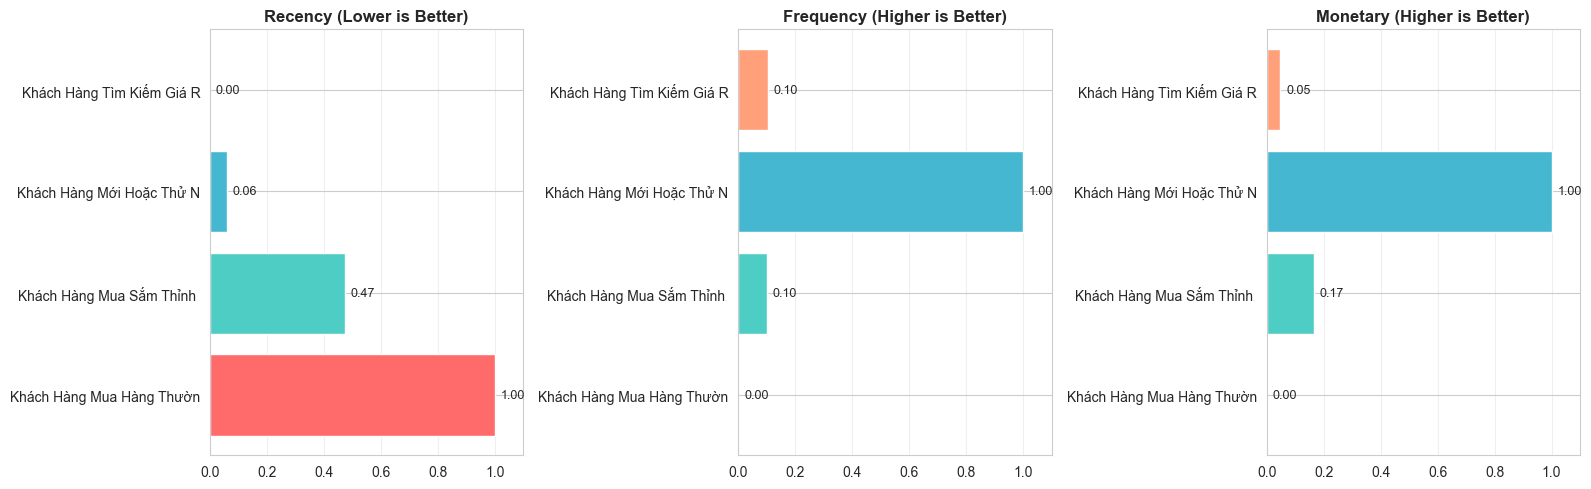

✓ RFM heatmap saved


In [12]:
# Create RFM heatmap
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Normalize RFM for heatmap
rfm_normalized = rfm_stats_df.copy()
for metric in ['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean']:
    min_val = rfm_stats_df[metric].min()
    max_val = rfm_stats_df[metric].max()
    rfm_normalized[metric] = (rfm_stats_df[metric] - min_val) / (max_val - min_val)

metrics_to_plot = [
    ('Recency_Mean', 'Recency (Lower is Better)', axes[0]),
    ('Frequency_Mean', 'Frequency (Higher is Better)', axes[1]),
    ('Monetary_Mean', 'Monetary (Higher is Better)', axes[2])
]

for metric, title, ax in metrics_to_plot:
    cluster_names = [cluster_profiles[i]['vi_name'][:25] for i in range(len(cluster_profiles))]
    values = rfm_normalized[metric].values
    
    bars = ax.barh(range(len(values)), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(cluster_names, fontsize=10)
    ax.set_xlim(0, 1.1)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # Add values on bars
    for i, (bar, val) in enumerate(zip(bars, rfm_normalized[metric])):
        ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=9)

plt.tight_layout()
plt.savefig(CLUSTERS_DIR / 'rfm_heatmap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ RFM heatmap saved")

## 12. Tổng Kết: Marketing Action Plan

In [13]:
print("\n" + "="*140)
print("MARKETING ACTION PLAN - TỔNG KẾT")
print("="*140)

action_plan = {
    'Priority': [
        ('🔴 PRIORITY 1: Cụm 0 - High-Value Consistent Buyers', 
         'Nhóm khách đem lại doanh thu cao nhất. Focus: Retention + Upsell + Exclusive benefits'),
        ('🟡 PRIORITY 2: Cụm 1 - Occasional Premium Shoppers',
         'Khách có potentials cao nhưng không thường xuyên. Focus: Re-engagement + Seasonal campaigns'),
        ('🟢 PRIORITY 3: Cụm 2 & 3 - New/Value Seekers',
         'Nhóm đầu vào. Focus: Convert to repeat customers + Increase basket size')
    ],
    'Quick_Wins': [
        'Launch VIP Loyalty Program (target Cluster 0): 15% discount + early access',
        'Re-engagement campaign (Cluster 1): Email series + exclusive offer, expected ROI 3-5x',
        'Welcome Program (Cluster 2): First-purchase incentive + educational content',
        'Bulk discount strategy (Cluster 3): Volume-based pricing to increase average order value'
    ],
    'Metrics_to_Track': [
        'Repeat purchase rate (especially Cluster 2 conversion)',
        'Average order value (AOV) growth by cluster',
        'Customer lifetime value (CLV) trajectory',
        'Churn rate (especially Cluster 0 retention)',
        'Campaign response rate by segment'
    ]
}

print("\n1️⃣ PRIORITY RANKING:")
for priority, desc in action_plan['Priority']:
    print(f"\n  {priority}")
    print(f"     → {desc}")

print("\n\n2️⃣ QUICK WINS (Implement ngay):")
for i, action in enumerate(action_plan['Quick_Wins'], 1):
    print(f"  {i}. {action}")

print("\n\n3️⃣ KEY METRICS TO MONITOR:")
for i, metric in enumerate(action_plan['Metrics_to_Track'], 1):
    print(f"  {i}. {metric}")

print("\n" + "="*140)
print("✅ PROFILING AND INTERPRETATION COMPLETE")
print("="*140)


MARKETING ACTION PLAN - TỔNG KẾT

1️⃣ PRIORITY RANKING:

  🔴 PRIORITY 1: Cụm 0 - High-Value Consistent Buyers
     → Nhóm khách đem lại doanh thu cao nhất. Focus: Retention + Upsell + Exclusive benefits

  🟡 PRIORITY 2: Cụm 1 - Occasional Premium Shoppers
     → Khách có potentials cao nhưng không thường xuyên. Focus: Re-engagement + Seasonal campaigns

  🟢 PRIORITY 3: Cụm 2 & 3 - New/Value Seekers
     → Nhóm đầu vào. Focus: Convert to repeat customers + Increase basket size


2️⃣ QUICK WINS (Implement ngay):
  1. Launch VIP Loyalty Program (target Cluster 0): 15% discount + early access
  2. Re-engagement campaign (Cluster 1): Email series + exclusive offer, expected ROI 3-5x
  3. Welcome Program (Cluster 2): First-purchase incentive + educational content
  4. Bulk discount strategy (Cluster 3): Volume-based pricing to increase average order value


3️⃣ KEY METRICS TO MONITOR:
  1. Repeat purchase rate (especially Cluster 2 conversion)
  2. Average order value (AOV) growth by cluste